# 课时72 常见预训练网络模型及使用示例(Xception)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('darkgrid')
# pathlib相比os.path更好用
import pathlib
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


# 1. 获取数据并做处理

In [30]:
data_path = 'D:/BaiduNetdiskDownload/日月光华-tensorflow资料/数据集/dc_2000'
train_images_path = glob.glob(pathname=data_path+'/train/*/*.jpg')
len(train_images_path)

2000

In [31]:
train_images_label = [int(path.split('\\')[1]=='cat') for path in train_images_path]

In [32]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[256, 256])
    image = tf.cast(image, tf.float32)
    image = image / 255
    return image, label

In [33]:
train_images_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_images_label))
AUTOTUNE = tf.data.experimental.AUTOTUNE 
train_images_dataset = train_images_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_images_dataset

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

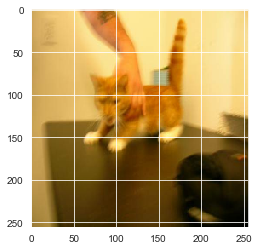

In [34]:
for img, label in train_images_dataset.take(1):
    plt.imshow(img)

In [35]:
BATCH_SIZE = 32
train_count = len(train_images_path)
train_images_dataset = train_images_dataset.shuffle(buffer_size=train_count).repeat().batch(batch_size=BATCH_SIZE)

In [36]:
test_images_path = glob.glob(pathname=data_path+'/test/*/*.jpg')
test_count = len(test_images_label)
test_images_label = [int(path.split('\\')[1]=='cat') for path in test_images_path]
test_images_dataset = tf.data.Dataset.from_tensor_slices((test_images_path, test_images_label))
test_images_dataset = test_images_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_images_dataset = test_images_dataset.repeat().batch(batch_size=BATCH_SIZE)

# 2. tf.keras内置经典网络实现 + 迁移学习

In [3]:
# 卷积基(conv_base)
conv_base = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                    include_top=False,
                                                    input_shape=(256, 256, 3),
                                                    pooling='avg')
# 在进行训练之前我们需要冻住预训练模型中卷积基的训练好的参数
conv_base.trainable = False
# conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [38]:
# 现在已经拿到了预训练的VGG16模型的卷积基，需要跟我们当前任务的新搭建的全连接分类模块进行组合
model = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
# model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 模型编译和训练
initial_epochs=5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(train_images_dataset,
                    steps_per_epoch=train_count // BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=test_images_dataset,
                    validation_steps=test_count)

# 3. 迁移学习——微调

>**迁移学习-微调**: 
>1. 所谓微调指的是冻结模型库的底部的卷积层，然后共同训练新添加的全连接分类器层和顶部部分卷积层，这允许我们"微调"基础模型中的高阶特征表示，以使它们与特定任务更相关。
>2. 需要注意的是只有在分类器已经训练好了的情况下，才能微调卷积基的顶部卷积层。因为刚开始的时候新定义的分类器还没开始训练的时候的训练误差是很大的，这时候如果和顶部的卷积层一起进行训练的话，这时会的反向传播的误差会使得微调之前这些卷积层学习到的表示(**representation**)会被破坏掉。
>3. 微调的步骤：
>>- 在预训练卷积基上添加自定义层;
>>- 冻结卷积基所有层;
>>- 训练添加的分类层;
>>- 解冻卷积基的一部分层;
>>- 联合训练解冻的卷积层和添加的自定义层.

In [42]:
# 当上面的模型训练完毕之后，可以开始进行微调，首先解冻
conv_base.trainable = True
len(conv_base.layers)

19

In [43]:
# 确定要进行微调的卷积层顶部需要解冻多少层(这里假设需要解冻最后三层卷积层进行微调)
fine_tune_at = -33
# 由于刚刚已经解冻了所有的卷积层，现在又需要微调最后三层，那么将卷积层第一层到倒数第三层之前的层给冻住
for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [4]:
# 模型编译和训练
model.compile(# 需要注意的是在进行微调的时候需要将学习率设置得更低
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005/10), 
              loss='binary_crossentropy', 
              metrics=['acc'])
# 设定微调需要训练多少个epochs
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history = model.fit(train_images_dataset,
                    steps_per_epoch=train_count // BATCH_SIZE,
                    epochs=total_epochs,
                    initial_epochs = initial_epochs,
                    validation_data=test_images_dataset,
                    validation_steps=test_count)